In [107]:
%matplotlib inline

import pandas as pd
import numpy as np
from utility_functions import report
# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest


import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

 _______________________________________________
# Binary Classification - Rock & Jazz
## # echonest audio features
 _______________________________________________

# 1. Preprocessing

In [41]:
# read dataset
echo_genres = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Datasets/echo_features.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()
echo_genres.drop('listens', axis=1, inplace=True)

In [42]:
# select subset of data with genres: Hip Hop or Rock
dataset = echo_genres[echo_genres['genre_top'].isin(['Rock','Jazz'])]
dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,duration,bit_rate,comments
track_id,,,,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz,82,256,0
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz,326,256,0
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz,354,256,0
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz,232,256,0
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock,405,256,0


In [43]:
# check shape
dataset.shape

(4133, 12)

In [44]:
#display counts and percentage of labels
pd.concat([dataset.genre_top.value_counts(),
                round(dataset.genre_top.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,3892,94.17
Jazz,241,5.83


In [45]:
# encoding labels
le = preprocessing.LabelEncoder()
dataset['genre_top'] = le.fit_transform(dataset['genre_top'])
print('legend:\n0: Jazz\n1: Rock')
dataset.genre_top.value_counts()

legend:
0: Jazz
1: Rock


1    3892
0     241
Name: genre_top, dtype: int64

In [46]:
# Define the labels
labels = dataset[['genre_top']]
# labels has as index the id_track, this creates problems when plotting data after the features have been normalized.
# we reset the index from 0 to n
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [47]:
dataset.drop('genre_top', axis=1, inplace=True)

In [48]:
# normalize the dataset
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset)
scaled_features

array([[ 1.02985274,  0.31691984,  0.07801309, ..., -0.74576189,
         0.19265136, -0.05688504],
       [-0.75595289,  0.28577395, -0.51298494, ...,  0.36763498,
         0.19265136, -0.05688504],
       [ 0.03025499,  0.15425321, -0.55639444, ...,  0.49540183,
         0.19265136, -0.05688504],
       ...,
       [-1.32137482,  1.53890309,  1.2777149 , ..., -0.07042281,
         1.39291979, -0.05688504],
       [-1.29503999,  1.73814459,  1.32968483, ..., -0.13886933,
         1.39291979, -0.05688504],
       [-1.3662832 , -0.77481062,  0.93070439, ..., -0.10692762,
         1.39291979, -0.05688504]])

# 2. PCA on normalized data (scaled_features)
## 2.1 Determine optimal number of components
### a) scree-plot
We use PCA to determine by how much we can reduce the dimensionality of our data.
We can use scree-plots and cumulative explained ratio plots to find the number of components to
use in further analysis.
- Screen-plots display the number of components against the variance explained by each component,sorted
in descending order of variance.
The cutoff is determined by the 'elbow' of the screen plot.

Text(0.5, 0, 'Principal Component #')

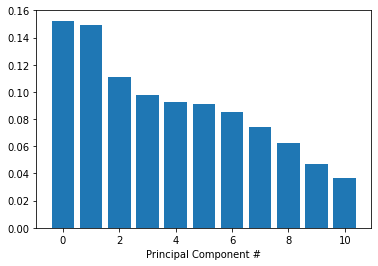

In [49]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

From the plot we can see that is not straightforward to identify the optimal number of components.
We will determine the optimal number of components by inspecting the cumulative explained
variance plot.

### b) cumulative explained variance plot

Optimal number of components: 8
Explained variation per principal component:
[0.15243228 0.14947487 0.11081465 0.09762929 0.09293618 0.09084448
 0.08560385 0.07444729 0.06228732 0.04716419 0.0363656 ]


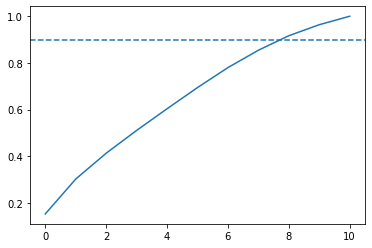

In [50]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)
# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=42)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

## 2.2 Plot PCA in 2D

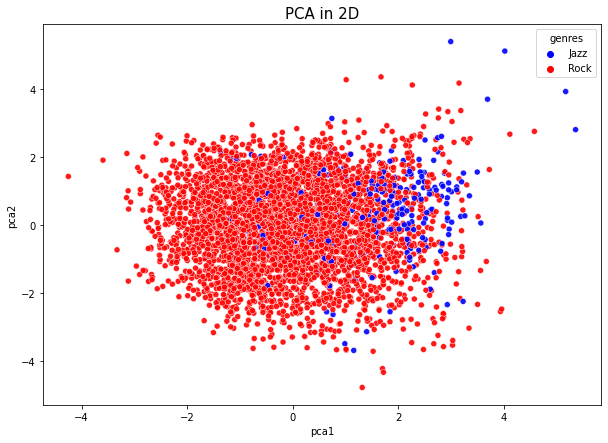

In [51]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2] # used for 3D plot
df['genres'] = labels.apply(lambda x: "Rock" if x==1 else "Jazz")

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    palette={'Jazz':'blue','Rock':'red'},
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

### 2.3 Plot PCA in 3D

In [52]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='genres',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
))
fig.show()

# 3. Split data for classification

In [53]:
# shuffle and split into development set and internal test set:
# (PCA)
X_pca, X_test_pca, y_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=42, stratify=labels)

# (split without PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=42,stratify= labels)

In [54]:
# check partition
print(f"____Legend____\n1: Rock\n0: Jazz\n\n***PCA***\nDevelopment set:\
\n{y_pca.value_counts()}\n\nInternal Test:\n{y_test_pca.value_counts()}\n\n\
-----------------\n\
***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
1: Rock
0: Jazz

***PCA***
Development set:
1    2724
0     169
Name: genre_top, dtype: int64

Internal Test:
1    1168
0      72
Name: genre_top, dtype: int64

-----------------
***No-PCA***
Development set:
1    2724
0     169
Name: genre_top, dtype: int64

Internal Test:
1    1168
0      72
Name: genre_top, dtype: int64


# 4. Decision Tree
### a) Full dimensionality

#### - Validation Schema: coarse grid-search with 5 fold CV
We adopt a 5 fold cross validation repeated 10 times and then averaged, in order to reduce the variance of the model.

In [93]:
# search parameters
param_grid = {
               "max_depth": [4,5,6,7,8,9,10],
               "min_samples_leaf": [10,15,25,20,35,45,55],
               "min_samples_split":[10,20,30,40,50],
               "criterion": ["gini", "entropy"]
             }
# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop, y_develop)
# display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 10 folds for each of 490 candidates, totalling 4900 fits
best parameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 20}
accuracy: 0.9415861376553061
Model with rank: 1
Mean validation score: 0.942 (std: 0.008)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 20}

Model with rank: 2
Mean validation score: 0.941 (std: 0.008)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.941 (std: 0.008)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 30}



#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc

The roc curve will be saved as:
- roc_auc0

The false and true positive rates will be saved as:
- fpr0
- tpr0

In [94]:
# train and fit
dtc = DecisionTreeClassifier(criterion= 'gini',max_depth=4, min_samples_leaf= 15, min_samples_split=20)
dtc.fit(X_develop,y_develop)
# predict on internal test set
y_pred_dtc = dtc.predict(X_test)

# display metrics
print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

Accuracy 0.9330645161290323
F1-score [0.12631579 0.96519916]
              precision    recall  f1-score   support

           0       0.26      0.08      0.13        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.93      1240
   macro avg       0.60      0.53      0.55      1240
weighted avg       0.91      0.93      0.92      1240



#### ROC Curve

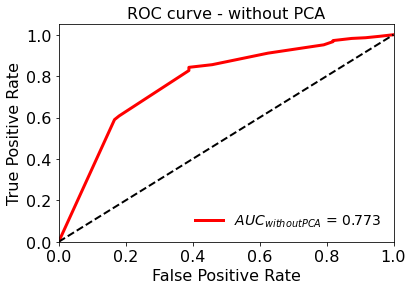

In [95]:
# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion Matrix

Legend:
0: Jazz
1: Rock
[[   6   66]
 [  17 1151]]


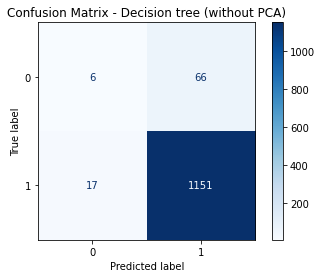

In [96]:
# confusion matrix - Internal Test
print("Legend:\n0: Jazz"
      "\n1: Rock")
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA
#### Validation schema:  repeated 5 fold cross validation - grid search

In [97]:
# model
dtc_pca = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)

clf.fit(X_pca, y_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

report(clf.cv_results_)

Fitting 10 folds for each of 490 candidates, totalling 4900 fits
best parameters:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 30}
accuracy: 0.9427975091286133
Model with rank: 1
Mean validation score: 0.943 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 30}

Model with rank: 1
Mean validation score: 0.943 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 30}

Model with rank: 1
Mean validation score: 0.943 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.943 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 20}

Model with rank: 1
Mean validation score: 0.943 (std: 0.012)
Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 40

#### - Train and predict
The model is retrained on the full development set.

The prediction will be saved as:
- y_pred_dtc_pca

The roc curve will be saved as:
- roc_auc1

The false and true positive rates will be saved as:
- fpr1
- tpr1

In [98]:
dtc_pca = DecisionTreeClassifier(criterion= 'gini',max_depth=5, min_samples_leaf= 20,min_samples_split=30)
dtc_pca.fit(X_pca,y_pca)

y_pred_dtc_pca = dtc_pca.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

Accuracy 0.9354838709677419
F1-score [0.29824561 0.96618766]
              precision    recall  f1-score   support

           0       0.40      0.24      0.30        72
           1       0.95      0.98      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.68      0.61      0.63      1240
weighted avg       0.92      0.94      0.93      1240



#### ROC curve

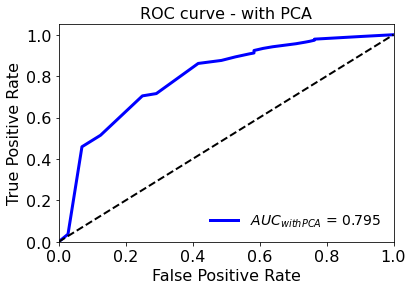

In [99]:
# y_score1 --> scores of decision tree with PCA
# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA
y_score1 = dtc_pca.predict_proba(X_test_pca)
fpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])

# roc_auc1 --> ROC/AUC of decision tree with PCA
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  17   55]
 [  25 1143]]


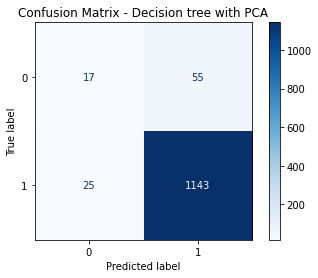

In [100]:
# confusion matrix Decision tree with PCA
print("Legend:\n0: Jazz\n1: Rock")
cm_pca = plot_confusion_matrix(dtc_pca,X_test_pca,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

### c) Comparing Decision tree with and without PCA

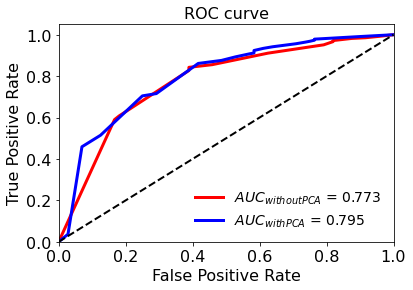

In [101]:
# ROC of decision tree without PCA
plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)
# ROC of decision tree with PCA
plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


### Decision tree built with Univariate Feature selection

In [113]:
sel = SelectKBest(k=7)

X_develop_sel = sel.fit_transform(X_develop, y_develop)
X_develop_sel.shape

(2893, 7)

In [114]:
# search parameters
param_grid = {
               "max_depth": [4,5,6,8,10],
               "min_samples_leaf": [5,10,25,20,35,40,45],
            "min_samples_split":[5,10,15,20,25,30],
               "criterion": ["gini", "entropy"]
             }

# instantiate a model
dtc = DecisionTreeClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(dtc, cv =rep_kfold , param_grid=param_grid, n_jobs=2, verbose=True)
clf.fit(X_develop_sel, y_develop)

#display top 3 models
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")
report(clf.cv_results_)

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
best parameters:
{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5}
accuracy: 0.9417579528001386
Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 5}

Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 10}

Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 20}



In [115]:
X_test_sel = sel.transform(X_test)

dtc_sel = DecisionTreeClassifier(criterion= 'gini',max_depth=4, min_samples_leaf= 10, min_samples_split=5)
dtc_sel.fit(X_develop_sel,y_develop)

y_pred_dtc = dtc_sel.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))


Accuracy 0.9338709677419355
F1-score [0.18       0.96554622]
              precision    recall  f1-score   support

           0       0.32      0.12      0.18        72
           1       0.95      0.98      0.97      1168

    accuracy                           0.93      1240
   macro avg       0.63      0.55      0.57      1240
weighted avg       0.91      0.93      0.92      1240



Legend:
0: Jazz
1: Rock
[[   9   63]
 [  19 1149]]


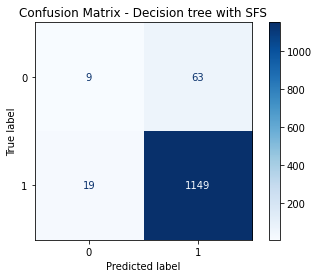

In [116]:
# confusion matrix Decision tree with PCA
print("Legend:\n0: Jazz\n1: Rock")
cm = plot_confusion_matrix(dtc_sel,X_test_sel,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree with SFS')
print(cm.confusion_matrix)
plt.show()

In [68]:
# 5. KNN
### a) Unbalanced - without PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [69]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_develop, y_develop)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'n_neighbors': 5}
accuracy: 0.9462520393710669


#### Train and predict

In [70]:
knn =  KNeighborsClassifier(n_neighbors = 11)
# retrain knn on the whole development set
knn.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn.predict(X_test)

# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.50      0.15      0.23        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.72      0.57      0.60      1240
weighted avg       0.92      0.94      0.93      1240

legend:
0: Jazz
1: Rock


#### ROC curve

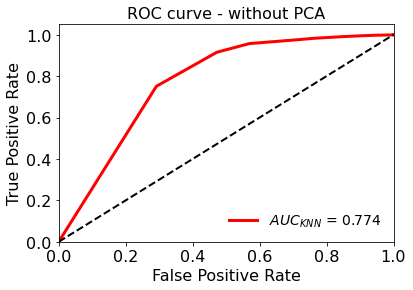

In [71]:
y_score_knn0 = knn.predict_proba(X_test)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn0 = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  11   61]
 [  11 1157]]


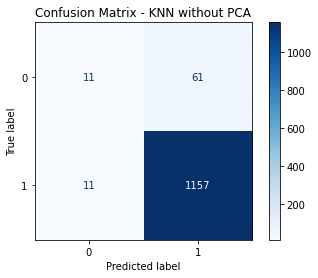

In [72]:
# confusion matrix KNN - Internal test
print("Legend:\n0: Jazz\n1: Rock")
cm_knn = plot_confusion_matrix(knn,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

### b) Unbalanced - with PCA

#### Validation schema: coarse grid search with repeated 5 fold cross validation

In [73]:
# range of k to try - find a good range of k
k_range = {"n_neighbors":[x for x in range(2, 50)]}

knn = KNeighborsClassifier()
rep_kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)
clf = GridSearchCV(knn, param_grid= k_range, cv=rep_kfold )
clf.fit(X_pca, y_pca)
print(f"best parameters:\n{clf.best_params_}\naccuracy: {clf.best_score_}")

#report(clf.cv_results_)

best parameters:
{'n_neighbors': 12}
accuracy: 0.9462529357979095


#### Train and predict

In [74]:
knn_pca =  KNeighborsClassifier(n_neighbors = 22)
# retrain knn on the whole development set
knn_pca.fit(X_pca, y_pca)
# predict target variable
y_pred_knn1 = knn_pca.predict(X_test_pca)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))
print('legend:\n0: Jazz\n1: Rock')

              precision    recall  f1-score   support

           0       0.56      0.14      0.22        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.75      0.57      0.60      1240
weighted avg       0.93      0.94      0.93      1240

legend:
0: Jazz
1: Rock


####  ROC curve

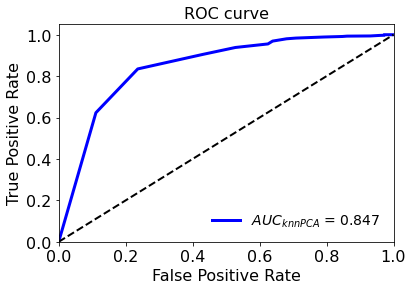

In [75]:
y_score_knn1 = knn_pca.predict_proba(X_test_pca)
fpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

#### Confusion matrix

Legend:
0: Jazz
1: Rock
[[  10   62]
 [   8 1160]]


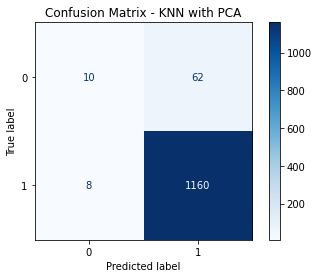

In [76]:
print("Legend:\n0: Jazz\n1: Rock")
cm_knn_pca = plot_confusion_matrix(knn_pca,X_test_pca,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()

### c) Comparing KNN with and without PCA

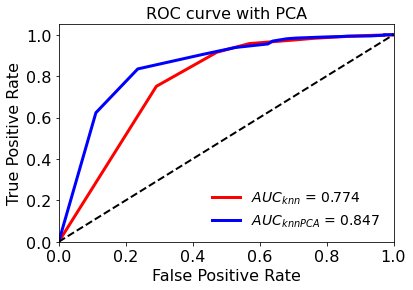

In [77]:
# ROC KNN without PCA
plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{knn}$ = %.3f' % roc_auc_knn0)
# ROC KNN with PCA
plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Compare Decision tree and KNN (best scores)

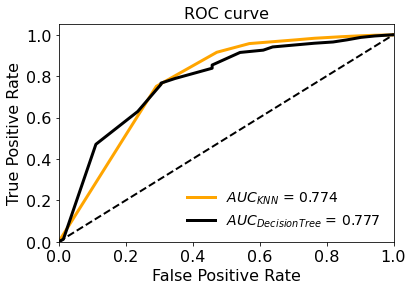

In [78]:
plt.plot(fpr_knn0, tpr_knn0, color='orange', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr0, tpr0, color='black', lw=3, label='$AUC_{DecisionTree}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()